### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


In [1]:
# < A whole lot of your code > - models, charts, analysis

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
import itertools
from tqdm.auto import tqdm

import nltk

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/Users/16971921/.conda/envs/py38_venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!

# data

In [4]:
# !wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
# data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

## целевое событие

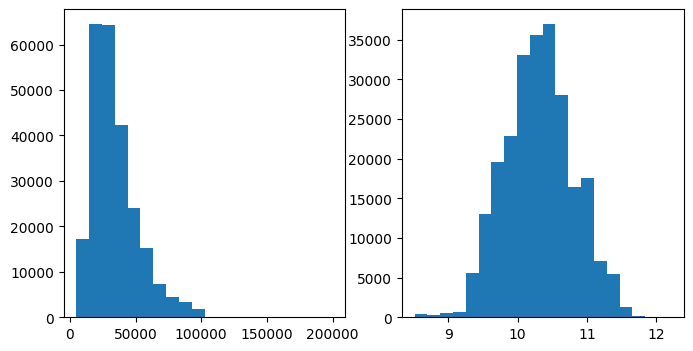

In [5]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

## группы полей объясняющих признаков

In [6]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
144881,70676364,Account Manager / Sales Executive,Job Title Account Manager / Sales Executive / ...,"South East England,London,Reading,Staines,Woki...",London,NaN,permanent,Mead House,Sales Jobs,35k - 45k pa + OTE 70-90k + Car + Benefits,40000,jobsite.co.uk,10.596660
123669,69961646,Junior Account Manager,Manchester based PR Agency is looking for a Ju...,Manchester,Manchester,NaN,NaN,NaN,"PR, Advertising & Marketing Jobs","22,000 - 25,000",23500,onlymarketingjobs.com,10.064798
31299,68074751,Relief Support Workers,We are looking to recruit a talented and highl...,Bradford West Yorkshire Yorkshire,Bradford,part_time,NaN,Creative Support,Charity & Voluntary Jobs,7.10 per hour plus accrued holiday credit,13632,totaljobs.com,9.520248


## преобразование категориальных данных

In [7]:
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

## преобразование текстовых данных

### токенизация текстовых полей

In [8]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

for i in text_columns:
    data[i] = data[i].str.lower()
    data[i] = data[i].astype(str).apply(tokenizer.tokenize)
    
data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
179242,71560416,"[branch, assistant]","[standards, at, all, times, ?, then, working, ...",Cwmbran,Cwmbran,part_time,NaN,Other,Customer Services Jobs,6.19 - 6.47 per hour,12153,Jobcentre Plus,9.405414
152112,70772444,"[contentious, constuction, solicitor, ****, pqe]","[contentious, construction, solicitor, ****, p...",West Midlands,West Midlands,NaN,permanent,Other,Legal Jobs,30000 - 40000 per annum,35000,legalweekjobs.com,10.463132
185861,71676414,"[production, manager]","[a, rapidly, growing, production, company, are...",Didcot Oxfordshire South East,Didcot,NaN,permanent,Other,Engineering Jobs,"From 25,000 to 25,000 per annum",25000,totaljobs.com,10.126671


### создание Словаря

##### подсчитываем, сколько раз каждое слово встречалось

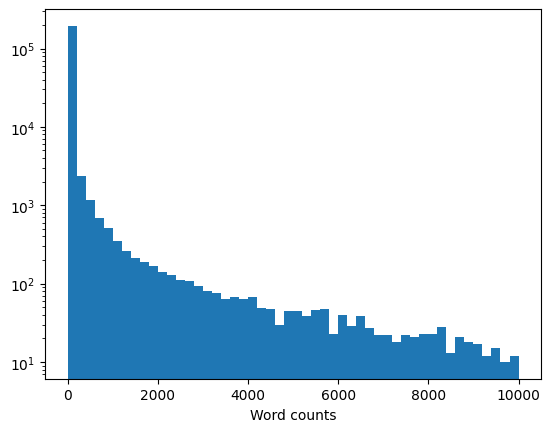

In [9]:
word_list_1 = data["Title"].tolist()
word_list_1 = list(itertools.chain(*word_list_1))

word_list_2 = data["FullDescription"].tolist()
word_list_2 = list(itertools.chain(*word_list_2))

word_list_1.extend(word_list_2)
token_counts = Counter(word_list_1)

plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

##### удаляем редкие слова, добавляем управляющих токены unknown и empty words -> список токенов

In [10]:
min_count = 10

tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

##### индексация каждого токена

In [11]:
token_to_id = {i: tokens.index(i) for i in tokens} 

### конвертация листа токенов в матрицу с паддингом

In [12]:
# получение индексов для управляющих токенов
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=10): #max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    # если строка не токенезирована, сделаем это 
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    # матрица, заполненная индексом [PAD] размерности n x max_len
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    # заполняем созданную матрицу "словами"
    for i,seq in enumerate(sequences):
        # если встречается незнакомый токен, то ставин индекс токена [UNK]
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        # замена соответсвующих строк в ранее созданной матрице нулей
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

# train-test split

In [13]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


# функция создание батчей

In [14]:
def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    # бинарная матрица, отвечающая за взятие (0) или исключение (1) элементов
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    # корректируем бинарную матрицу, если токен [PAD] (пустое слово), то ставим 0
    dropout_mask &= matrix != pad_ix
    # dropout_mask: 0 - берется элемент из левой матрицы, 1 - из правой
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

# функции итерирования батче и визуализации прогресса обучения

In [15]:
BATCH_SIZE = 16
EPOCHS = 5

def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, max_len=898, **kwargs)
            yield batch
        
        if not cycle: break
            
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            print('-')
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
            break
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

# обучение модели

## base-модель

In [16]:
class SalaryPredictor_1(nn.Module):
    # конструктор класса
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        # создание сетки по канонам созданного класса
        super().__init__()
        
        self.embedding = nn.Embedding(num_embeddings=n_tokens, embedding_dim=256)
        self.conv_t = nn.Conv1d(898, hid_size, kernel_size=7, padding="same")
        self.pool = nn.MaxPool1d(4)
        #-----------------------------------------
        self.conv_d = nn.Conv1d(898, hid_size, kernel_size=7, padding="same")
        #-----------------------------------------
        self.fc1 = nn.Linear(n_cat_features, hid_size)
        self.ac1 = nn.Sigmoid()
        #-----------------------------------------
        self.fc2 = nn.Linear(hid_size, 1 )
        self.fc3 = nn.Linear(192, 1 )
        self.relu = nn.ReLU()
        
    def forward(self, batch):
        x_tit = batch['Title']
        x_tit = self.embedding(x_tit)
        x_tit = self.conv_t(x_tit)
        x_tit = self.relu(x_tit)
        x_tit = self.pool(x_tit)
        #-----------------------------------------
        x_des = batch['FullDescription']
        x_des = self.embedding(x_des)
        x_des = self.conv_d(x_des)
        x_des = self.relu(x_des)
        x_des = self.pool(x_des)
        #-----------------------------------------
        x_cat = batch['Categorical']
        x_cat = self.fc1(x_cat)
        x_cat = self.ac1(x_cat)
        #-----------------------------------------
        x_cat = x_cat.unsqueeze(2).expand(-1, -1, 64)
        x = torch.cat((x_tit, x_des, x_cat), dim=1)

        x = self.fc2(x)
        x.squeeze_()
        x = self.relu(x)
        
        x = self.fc3(x)
        x.squeeze_()
        x = self.relu(x)
        
        return x      

In [17]:
torch.manual_seed(43)

model = SalaryPredictor_1()
batch = make_batch(data_train[:100], max_len=898)
criterion = nn.MSELoss()

model(batch)

tensor([0.1202, 0.1729, 0.1301, 0.1577, 0.1173, 0.1380, 0.1262, 0.1442, 0.1336,
        0.1429, 0.1368, 0.0615, 0.1561, 0.0879, 0.1698, 0.1755, 0.0919, 0.1441,
        0.1524, 0.1676, 0.0934, 0.1082, 0.0524, 0.1336, 0.1759, 0.0976, 0.0815,
        0.1036, 0.1405, 0.1345, 0.1409, 0.1286, 0.1526, 0.1093, 0.0465, 0.1579,
        0.1271, 0.1449, 0.1497, 0.0742, 0.1506, 0.1016, 0.1114, 0.1475, 0.1955,
        0.1061, 0.0823, 0.1458, 0.0865, 0.1209, 0.1283, 0.1658, 0.1106, 0.1013,
        0.1408, 0.1395, 0.1035, 0.1631, 0.1300, 0.1521, 0.1063, 0.1048, 0.1266,
        0.0991, 0.1269, 0.1130, 0.1595, 0.1175, 0.1707, 0.0916, 0.1446, 0.1052,
        0.1390, 0.1528, 0.1393, 0.0799, 0.0836, 0.0890, 0.1279, 0.1376, 0.1325,
        0.1510, 0.1816, 0.2021, 0.1381, 0.0595, 0.1075, 0.0916, 0.0999, 0.1424,
        0.0923, 0.1436, 0.1880, 0.1488, 0.1078, 0.1523, 0.1242, 0.1739, 0.0658,
        0.1472], grad_fn=<ReluBackward0>)

In [18]:
torch.manual_seed(43)

model = SalaryPredictor_1().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        optimizer.zero_grad()
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()
        
        #if i==10: break
        
    print_metrics(model, data_val, device=device)

epoch: 0


12239it [1:16:15,  2.67it/s]                                                    

-
 results:
Mean square error: 0.08757
Mean absolute error: 0.23446


## модель A

In [19]:
class SalaryPredictor_2(nn.Module):
    # конструктор класса
    def __init__(self, 
                 n_tokens=len(tokens), 
                 n_cat_features=len(categorical_vectorizer.vocabulary_), 
                 hid_size=64,
                 p_dropout = 0.1
                ):
        # создание сетки по канонам созданного класса
        super().__init__()
        
        # YOUR CODE HERE
        self.embedding = nn.Embedding(num_embeddings=n_tokens, embedding_dim=256)
        
        self.conv_t_1 = nn.Conv1d(898, hid_size, kernel_size=7, padding="same")
        self.norm_t_1 = nn.BatchNorm1d(hid_size)
        self.conv_t_2 = nn.Conv1d(898, hid_size, kernel_size=7, padding="same")
        self.norm_t_2 = nn.BatchNorm1d(hid_size)
        self.dropout = nn.Dropout(p_dropout)
        self.pooling = nn.MaxPool1d(4) #256 / 64
        #-----------------------------------------
        self.conv_d = nn.Conv1d(898, hid_size, kernel_size=7, padding="same")
        self.norm_d = nn.BatchNorm1d(hid_size)
        #-----------------------------------------
        self.fc1 = nn.Linear(n_cat_features, hid_size)
        self.ac1 = nn.Sigmoid()
        #-----------------------------------------
        self.fc2 = nn.Linear(hid_size, 1 )
        self.fc3 = nn.Linear(320, 1 )
        
    def forward(self, batch):
        # YOUR CODE HERE
        
        x_tit = batch['Title']
        x_tit = self.embedding(x_tit)
        
        x_tit_1 = self.conv_t_1(x_tit)
        x_tit_1 = torch.relu(x_tit_1)
        x_tit_1 = self.norm_t_1(x_tit_1)
        x_tit_1 = self.dropout(x_tit_1)        
        x_tit_1 = self.pooling(x_tit_1)
        
        x_tit_2 = self.conv_t_2(x_tit)
        x_tit_2 = torch.relu(x_tit_2)
        x_tit_2 = self.norm_t_2(x_tit_2)
        x_tit_2 = self.dropout(x_tit_2)        
        x_tit_2 = self.pooling(x_tit_2)
        
        x_tit = torch.cat((x_tit_1, x_tit_2), dim=1)
        #-----------------------------------------
        x_des = batch['FullDescription']
        x_des = self.embedding(x_des)
        
        x_des_1 = self.conv_t_1(x_des)
        x_des_1 = torch.relu(x_des_1)
        x_des_1 = self.norm_t_1(x_des_1)
        x_des_1 = self.dropout(x_des_1)        
        x_des_1 = self.pooling(x_des_1)
        
        x_des_2 = self.conv_t_2(x_des)
        x_des_2 = torch.relu(x_des_2)
        x_des_2 = self.norm_t_2(x_des_2)
        x_des_2 = self.dropout(x_des_2)        
        x_des_2 = self.pooling(x_des_2)
        
        x_des = torch.cat((x_des_1, x_des_2), dim=1)
        #-----------------------------------------
        x_cat = batch['Categorical']
        x_cat = self.fc1(x_cat)
        x_cat = self.ac1(x_cat)
        x_cat = x_cat.unsqueeze(2).expand(-1, -1, 64)
        #-----------------------------------------
        
        x = torch.cat((x_tit, x_des, x_cat), dim=1)
        
        x = self.fc2(x)
        x.squeeze_()
        x = torch.relu(x)
        
        x = self.fc3(x)
        x.squeeze_()
        x = torch.relu(x)
        
        return x      

In [20]:
torch.manual_seed(43)

model = SalaryPredictor_2()
batch = make_batch(data_train[:100], max_len=898)
criterion = nn.MSELoss()

model(batch)

Title


tensor([0.0000, 0.0000, 0.0000, 0.0299, 0.0000, 0.0268, 0.0000, 0.0090, 0.0000,
        0.0000, 0.0973, 0.0361, 0.0303, 0.0000, 0.0075, 0.0022, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.1105, 0.0703, 0.1905, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1032, 0.0000, 0.0448, 0.0056, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0065, 0.0591, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.1079, 0.0000, 0.1210, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0050, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0151, 0.0000, 0.1022, 0.0000, 0.0000,
        0.0559, 0.0000, 0.0000, 0.0000, 0.1374, 0.1148, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0603, 0.1678, 0.0000, 0.0010, 0.0179, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0050, 0.0000, 0.0000, 0.0000, 0.0883,
        0.1282], grad_fn=<ReluBackward0>)

In [21]:
torch.manual_seed(43)

model = SalaryPredictor_2().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        optimizer.zero_grad()
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()
        
        if i==10: break
        
    print_metrics(model, data_val, device=device)
    
    # break

epoch: 0


  0%|                                                 | 0/12238 [00:00<?, ?it/s]

Title


  0%|                                       | 1/12238 [00:00<2:29:04,  1.37it/s]

Title


  0%|                                       | 2/12238 [00:01<2:22:16,  1.43it/s]

Title


  0%|                                       | 3/12238 [00:02<2:20:19,  1.45it/s]

Title


  0%|                                       | 4/12238 [00:02<2:17:12,  1.49it/s]

Title


  0%|                                       | 5/12238 [00:03<2:16:22,  1.49it/s]

Title


  0%|                                       | 6/12238 [00:04<2:14:23,  1.52it/s]

Title


  0%|                                       | 7/12238 [00:04<2:14:10,  1.52it/s]

Title


  0%|                                       | 8/12238 [00:05<2:12:50,  1.53it/s]

Title


  0%|                                       | 9/12238 [00:05<2:12:32,  1.54it/s]

Title


  0%|                                      | 10/12238 [00:06<2:12:41,  1.54it/s]

Title


  0%|                                      | 10/12238 [00:07<2:28:18,  1.37it/s]

-
Title
 results:
Mean square error: 54.91571
Mean absolute error: 7.39182


## модель B

 Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

## другие модели

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea